# Predicting Recipe Popularity to Boost Website Traffic

<b>Background</b>  
The product team has presented a new challenge related to optimizing the selection of recipes displayed on our website's homepage. The goal is to leverage data science to predict which recipes will be most popular among our audience, thereby increasing overall website traffic and, subsequently, subscriptions.  

<b>Project Overview</b>  
You are tasked with developing a predictive model to forecast recipe popularity with high accuracy. The expectation set by the product team is ambitious: to correctly predict high-traffic recipes 80% of the time. Although this target might be challenging within the given timeframe, your objective is to approach it as closely as possible and suggest practical recommendations based on your finding.

<b>Key Objectives</b>   
1. Predictive Analysis
    - Develop a predictive model that identifies potential high-traffic recipes. The model should aim for an accuracy target of predicting popular recipes 80% of the time, understanding that this is an ambitious goal.
2. Data Exploration
    - Thoroughly analyze the available recipe and traffic data to identify patterns or features that can inform the predictive model. This may include recipe ingredients, preparation time, seasonality, previous traffic data, and any other relevant factors.
3. Strategic Recommendation
    - Provide actionable recommendations based on your analysis. This could include suggestions for recipe selection criteria, adjustments to the prediction model, or other strategic insights that could help in choosing high-traffic recipes.
  
<b>Meta Data</b>  
The product manager has tried to make this easier for us and provided data for each recipe,
as well as whether there was high traffic when the recipe was featured on the home pag  .
Don’t forget to double check the data really does match what they say - it might not  
| Column Name   | Details                                                                                           |
|---------------|---------------------------------------------------------------------------------------------------|
| recipe        | Numeric, unique identifier of recipe                                                              |
| calories      | Numeric, number of calories                                                                       |
| carbohydrate  | Numeric, amount of carbohydrates in grams                                                         |
| sugar         | Numeric, amount of sugar in grams                                                                 |
| protein       | Numeric, amount of protein in grams                                                               |
| category      | Character, type of recipe. Recipes are listed in one of ten possible g  roupings ('Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'). |
| servings      | Numeric, number of servings for the recipe                                                        |
| high_traffic  | Character, if the traffic to the site was high when this recipe was shown, this is marke“High”. |
.

## Modules & source data

In [1]:
# Import modules
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the source data
source_data = 'recipe_site_traffic_2212.csv'
df = pd.read_csv(source_data)

# Set white style
sns.set_style("white")

## Data Validation

In [2]:
# Display the first 5 rows of the dataset
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
# Dislay descriptive statistics for numerical columns
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [4]:
# Display a summary of the dataset, including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [5]:
# Count the number of missing values in each column
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [6]:
# Count the number of unique values in the recipe column
len(df.recipe.unique())

947

In [7]:
# Check duplicated rows
print(len(df[df.duplicated()]))

0


In [8]:
# List of columns to be processed
string_cols = ['category', 'servings', 'high_traffic']

# Loop through each column and print column name, followed by value counts, and an empty line
for col in string_cols:
    print(col)
    print(df[col].value_counts())
    print("\n")

category
category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64


servings
servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64


high_traffic
high_traffic
High    574
Name: count, dtype: int64




The dataset contains 947 rows and 8 columns before cleaning and validataion. I have validated all the columns against the criteria in the dataset table:

- recipe: Numeric values representing recipes without missing values, same as the description. No cleaning is needed.

- calories: Numeric values with 52 missing values. Missing values will be imputed with the median value.

- carbohydrate: Numeric values with 52 missing values. Missing values will be imputed with the median value.

- sugar: Numeric values with 52 missing values. Missing values will be imputed with the median value.

- protein: Numeric values with 52 missing values. Missing values will be imputed with the median value.

- category: String values without missing values. _Chicken Breast_ needs replacing with _Chicken_

- servings: String values without missing values. _4 as a snack_ and _6 as a snack_ needs replacing with _4_ and _6_ respectively. Also, the column will be changed into a numeric one.

- high_traffic: String values with 373 missing values. For the sake of EDA, the missing values will be replaced with _Low_. Given this column is the target variable, this will be one-hot encoded later.

## Data Cleaning

In [9]:
# Create a dictionary with correct values
replace_dict = {'servings': {'4 as a snack': 4, '6 as a snack': 6},
                'category': {'Chicken Breast': 'Chicken'}}

# Replace the wrong data
df.replace(replace_dict, inplace=True)

# Change data type of the servings column
df['servings'] = df['servings'].astype(int)

# Replace nulls with Low in the target column
df['high_traffic'].fillna('Low', inplace=True)

# Make a list of the numeric columns
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create and fit an imputer on the numeric columns
df[numeric_columns] = SimpleImputer(strategy='median').fit_transform(df[numeric_columns])

In [10]:
# Last check before EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int32  
 7   high_traffic  947 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 55.6+ KB


## Exploratory Data Analysis

Around 61% of the total 947 recipes fall into the high-traffic generation group. Conversely, around 39% of the total recipe count corresponds to the low-traffic generation group.

C:\Users\marti\AppData\Local\Temp\ipykernel_21420\3342192442.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_traffic_percentage = df['high_traffic'].value_counts(normalize=True)[0] * 100


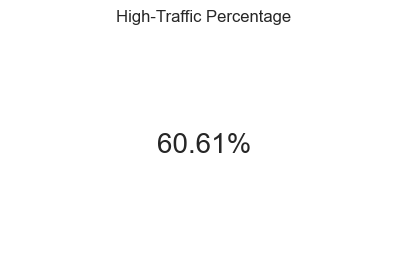

In [11]:
# Calculate the high traffic percentage
high_traffic_percentage = df['high_traffic'].value_counts(normalize=True)[0] * 100

# Create text-based visualization for high traffic percentage
plt.figure(figsize=(5, 3))
plt.text(0.5, 0.5, f'{high_traffic_percentage:.2f}%', fontsize=20, ha='center', va='center')
plt.axis('off')
plt.title('High-Traffic Percentage')
plt.show()

In the dataset, there are 4 Servings categories: 1, 2, 4, and 6. The most dominant is Servings with the value of 4 with 391 recipes followed by Servings with the value of 6 with 198 recipes.

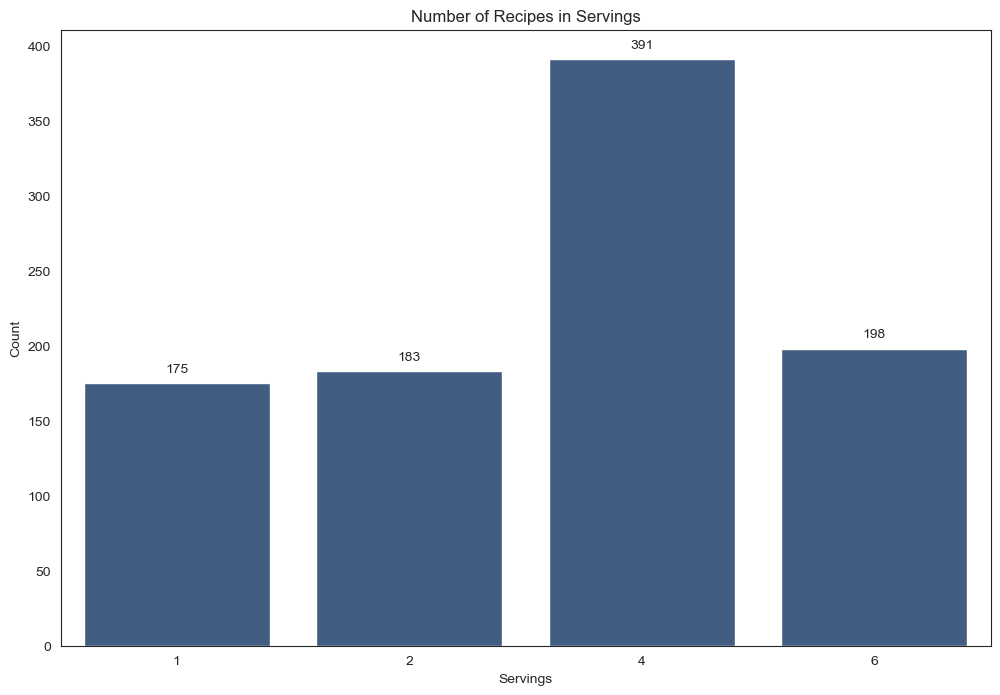

In [12]:
# Create a count plot
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='servings', data=df, color='#365c8d')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Number of Recipes in Servings')
plt.xlabel('Servings')
plt.ylabel('Count')
plt.show()

In total, there are 10 categories of recipes with Chicken having the highest count of 172, followed by Breakfast with 106, and Beverages with 92. Towards the lower end of the spectrum, categories such as One Dish Meal, Meat, Dessert, and Vegetable have relatively lower counts, ranging from 71 to 83 recipes.

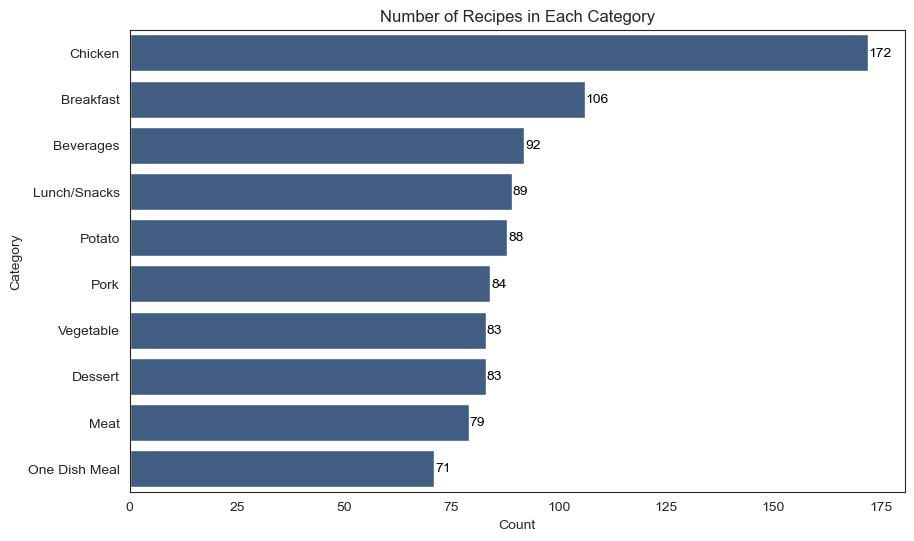

In [13]:
# Create a count plot, sorted by the number of recipes in each category
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='category', data=df, order=df['category'].value_counts().index, color='#365c8d')

# Add values right next to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width() + 0.2, p.get_y() + p.get_height() / 2), color='black', va='center')

plt.title('Number of Recipes in Each Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

The recipes in the Pork, Potato, and Vegetable categories are more likely to attract high traffic, while those in Breakfast, Beverages, and Chicken categories may have lower levels of engagement.

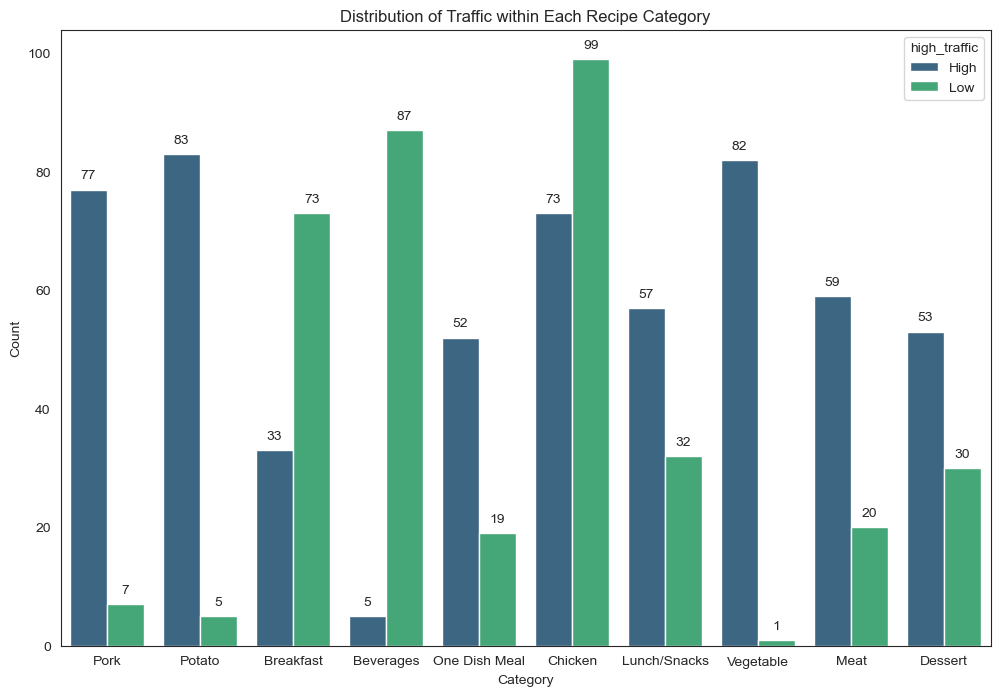

In [14]:
# Create a count plot
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='category', hue='high_traffic', data=df, palette='viridis')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Traffic within Each Recipe Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

The same insight is more highlighted when using a scatter plot that reveals an intriguing pattern where Pork, Potato, and Vegetables categories form a distinctive cluster, exhibiting a disproportionately high level of traffic generation relative to their modest share of around 9% among all categories.

high_traffic   High  Low  Total  Portfolio_Share  High_Traffic_Percentage
category                                                                 
Vegetable        82    1     83             8.76                    98.80
Potato           83    5     88             9.29                    94.32
Pork             77    7     84             8.87                    91.67
Meat             59   20     79             8.34                    74.68
One Dish Meal    52   19     71             7.50                    73.24
Lunch/Snacks     57   32     89             9.40                    64.04
Dessert          53   30     83             8.76                    63.86
Chicken          73   99    172            18.16                    42.44
Breakfast        33   73    106            11.19                    31.13
Beverages         5   87     92             9.71                     5.43


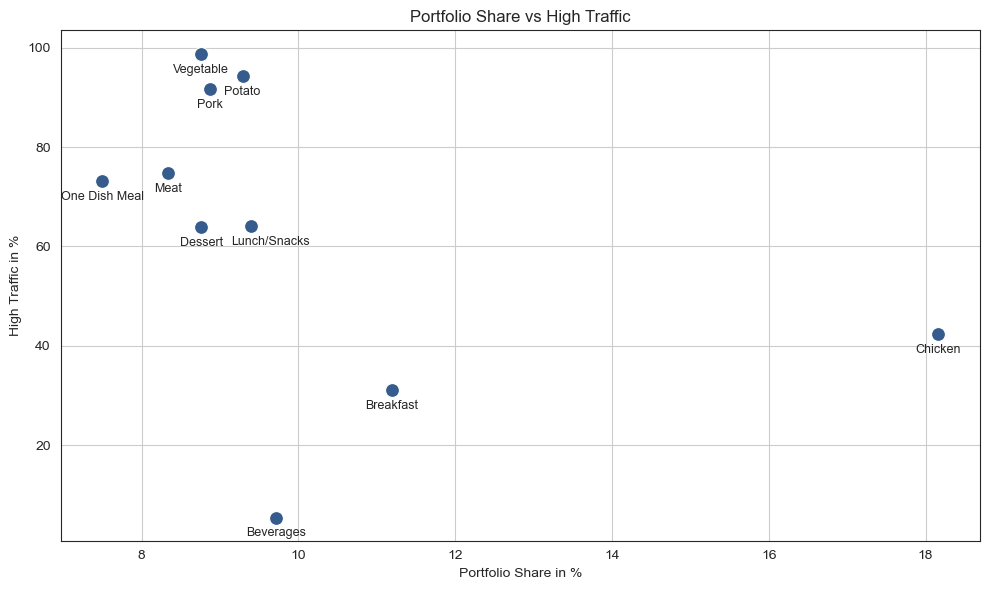

In [15]:
# Group by category and calculate the total counts of High and Low
category_counts = df.groupby(['category', 'high_traffic']).size().unstack(fill_value=0)

# Sum the High and Low columns into a single Total column
category_counts['Total'] = category_counts['High'] + category_counts['Low']

# Normalize the Total column to convert it to a percentage
category_counts['Portfolio_Share'] = (category_counts['Total'] / category_counts['Total'].sum()).mul(100).round(2)

# Calculate the high traffic percentage for each category
category_counts['High_Traffic_Percentage'] = (category_counts['High'] / category_counts['Total']).mul(100).round(2)

# Sort the table by High_Traffic_Percentage 
category_counts = category_counts.sort_values(by='High_Traffic_Percentage', ascending=False)

# Display the table
print(category_counts)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Portfolio_Share', y='High_Traffic_Percentage', data=category_counts, s=100, color='#365c8d')

# Add data labels
for category, x, y in zip(category_counts.index, category_counts['Portfolio_Share'], category_counts['High_Traffic_Percentage']):
    if category == 'Lunch/Snacks':
        plt.text(x + 0.25, y -2 , category, fontsize=9, ha='center', va='top')
    else:
        plt.text(x, y - 2 , category, fontsize=9, ha='center', va='top')


plt.title('Portfolio Share vs High Traffic')
plt.xlabel('Portfolio Share in %')
plt.ylabel('High Traffic in %')
plt.grid()
plt.tight_layout()
plt.show()

The data suggests that certain features (Calories, Carbohydrate, Sugar, Protein) have a noticeable difference in their distribution when it comes to recipes that attract higher traffic compared to those with lower traffic. Generally speaking, people might be more inclined towards recipes with a lower level of nutrition. Nutrient-rich recipes do not seem to attract the visitors.

C:\Users\marti\anaconda3\envs\martin-FIS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marti\anaconda3\envs\martin-FIS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marti\anaconda3\envs\martin-FIS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marti\anaconda3\envs\martin-FIS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

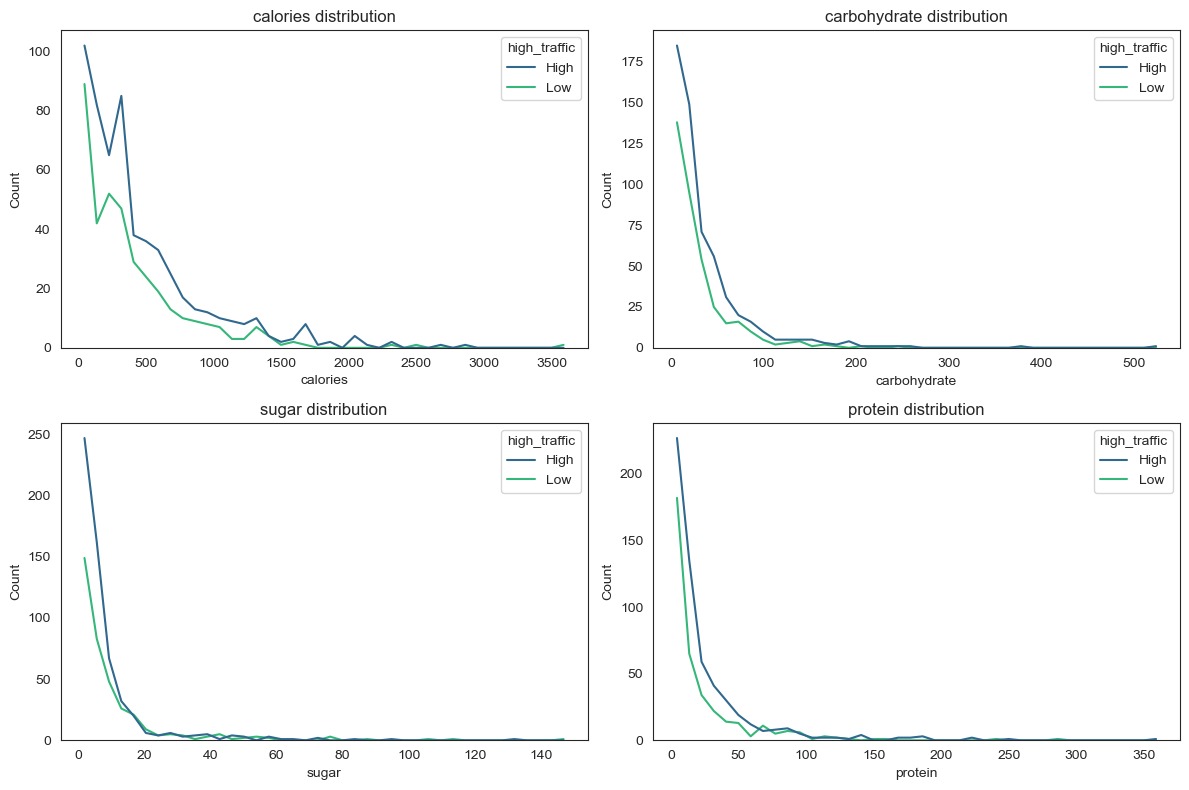

In [16]:
# Combine numeric columns and high_traffic variable
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
columns_to_plot = numeric_columns + ['high_traffic']
df_subset = df[columns_to_plot]

# Create histograms for each numeric variable with the target variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df_subset, x=col, hue='high_traffic', palette='viridis', element = 'poly', fill=False, bins = 40)
    plt.title(f'{col} distribution')
    
plt.tight_layout()
plt.show()

The nutrient variables displays a wide range of distribution across the dataset with the majority of the data concentrated towards the lower end of the spectrum. This could indicate that the nutrient variables have different scales, which might affect the classification model performance. As a result, scaling can be beneficial here.

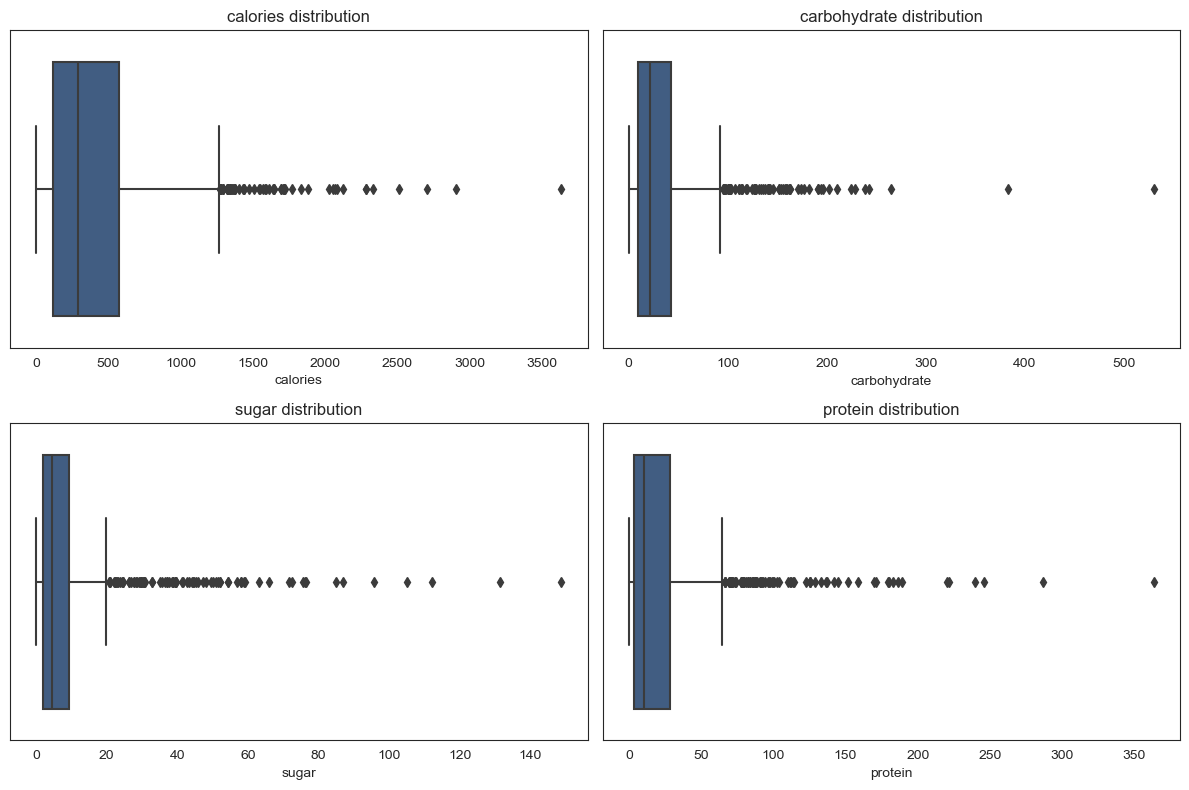

In [17]:
# Create box plots for each numeric variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_subset[col], color='#365c8d')
    plt.title(f'{col} distribution')

plt.tight_layout()
plt.show()

The relationship between recipe categories and nutrients illustrate intuitive patterns aligning with common sense. For instance, in the Sugar nutrient, the Dessert category stands out prominently. Meanwhile, Protein shows higher values in categories like Chicken, Pork, and Meat, reflecting protein-rich sources. Additionally, the Carbohydrate content is notably elevated in the Potato category, confirming expectations based on nutritional knowledge.

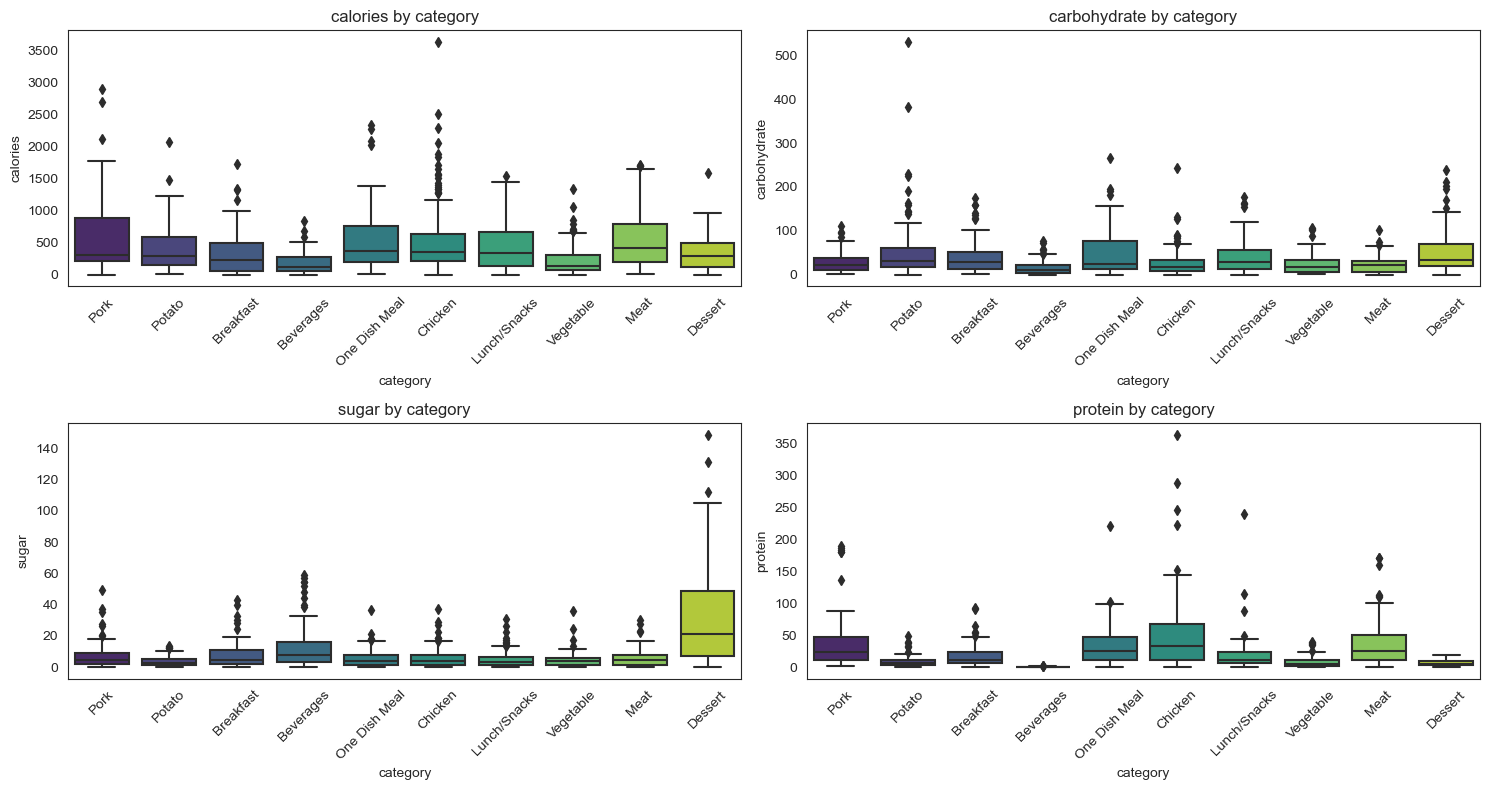

In [18]:
# Combine numeric columns and category variable
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
columns_to_plot = numeric_columns + ['category']
df_subset = df[columns_to_plot]

# Create box plots for each numeric variable grouped by category
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='category', y=col, data=df_subset, palette='viridis')
    plt.title(f'{col} by category')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Models

The modeling phase involves a **supervised classification** task, focusing on the binary target variable High_traffic. Two algorithms, namely Logistic Regression and Random Forest, will be employed to predict the likelihood of high traffic. The former serves as the baseline model, while the latter acts as the comparative model. 

The **Logistic Regression** model was selected as the baseline model due to its capacity for straightforward interpretation—its coefficients directly reflect feature importance. This model performs effectively when the relationship between features and the target variable is approximately linear. Furthermore, Logistic Regression is often favored for its simplicity and lower computational requirements, making it an easily deployable choice.

For each algorithm, the process begins with hyperparameter tuning, where various hyperparameter combinations are systematically explored using GridSearch. This allows the optimization of the performance of each model. Subsequently, the models are seamlessly deployed with the best-tuned parameters identified during the hyperparameter tuning process.

The goal is to assess the performance of these models in classifying recipes into high or low traffic categories based on the selected features. The evaluation will include metrics such as accuracy, precision, recall, and F1 score to evaluate the effectiveness of each algorithm. The key performance indicator (KPI) for this task is the **precision score**, as the company aims to achieve an 80% precision rate in correctly predicting high-traffic recipes.

### 1. Data Preparation

- Store Categories for later use in Business Focus chapter

- Scale the numeric columns (Calories, Carbohydrate, Sugar, Protein) to ensure uniformity and prevent any variable from dominating the model due to scale differences.

- Convert the categorical variable Category into numeric features, enabling the algorithm to work with categorical data.

- Encode the target variable High_traffic into 0 and 1.

- Remove the Recipe column as it serves as a mere identifier and does not contribute to the predictive task.

- Split the data in order to evaluate the models.

In [19]:
# Subset categories for later use
categories = df['category']

# Scale the numeric columns 
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Convert categorical variable category into numeric features
df = pd.get_dummies(df, columns=['category'])

# Encode the target variable high_traffic
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

# Train-Test Split
X = df.drop(columns=['high_traffic', 'recipe'])
y = df['high_traffic']

# Use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### 2. Logistic Regression

#### 2.1 Hyperparameters Tuning 

In [20]:
# Define hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_logreg_model = LogisticRegression(random_state=42, **best_params)
best_logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_logreg_model.predict(X_test)

# Evaluate the tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
classification_rep_best = classification_report(y_test, y_pred_best)

# Print the best hyperparameters and evaluation metrics
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'C': 1}


#### 2.2 With Hyperparameters

In [21]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42, **best_params)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

### 3. Random Forest

#### 3.1 Hyperparameters Tuning

In [22]:
# Define hyperparameters to tune
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='precision')
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# Train the model with the best hyperparameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
classification_rep_best_rf = classification_report(y_test, y_pred_best_rf)

# Print the best hyperparameters and evaluation metrics
print(f'Best Hyperparameters for Random Forest: {best_params_rf}')

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


#### 3.2 With Hyperparameters

In [23]:
# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42, **best_params_rf)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

### 4. Model Evaluation 

Both models demonstrate strong performance, with the Random Forest model slightly outperforming the Logistic Regression model in terms of overall accuracy and F1-score (the harmonic mean of precision and recall).

However, when it comes to precision (the KPI for this project) only, it is the Logistic Regression model that outperforms the Random Forest model.

In [24]:
# Evaluate the Logistic Regression model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f'Logistic Regression Accuracy: {accuracy:.4f}')
print('Logistic Regression Classification Report:\n', classification_rep)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics for Random Forest
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')
print('Random Forest Classification Report:\n', classification_rep_rf)

Logistic Regression Accuracy: 0.7737
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.79      0.73        75
           1       0.85      0.77      0.80       115

    accuracy                           0.77       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.78      0.77      0.78       190

Random Forest Accuracy: 0.7474
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.76      0.70        75
           1       0.83      0.74      0.78       115

    accuracy                           0.75       190
   macro avg       0.74      0.75      0.74       190
weighted avg       0.76      0.75      0.75       190



ROC AUC provides insights into the discriminatory power of the model, showcasing how well it separates instances of interest (high-traffic recipes) from non-interesting ones. 

AUC for the logistic regression model is 0.86, suggesting a good ability to discriminate between the positive and negative classes.

AUC for the random forest is 0.84, also indicating a reasonable ability to discriminate. 

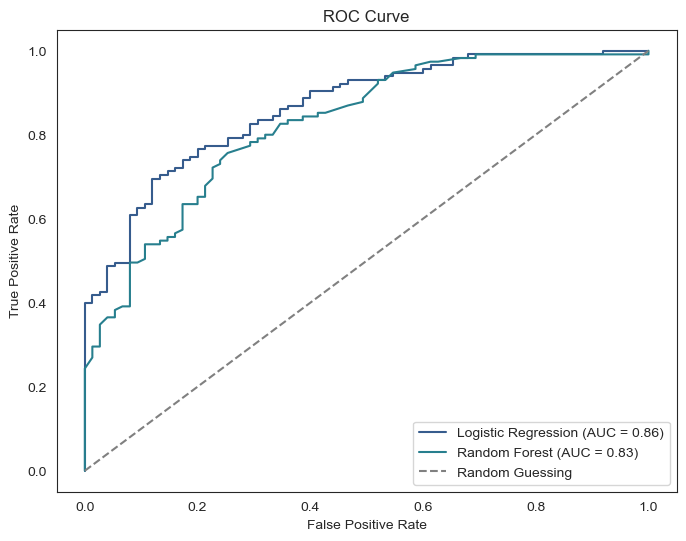

In [25]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, label, linestyle='-', c=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})', linestyle=linestyle, color=c)

# Predict probabilities for both models
y_prob_logreg = logreg_model.predict_proba(X_test)[:, 1]
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Compare ROC curves
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_logreg, label='Logistic Regression', c='#365c8d')
plot_roc_curve(y_test, y_prob_rf, label='Random Forest', c='#277f8e')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 5. Feature Importance of Logistic Regression

In Logistic Regression, feature importance is derived from the coefficients assigned to each feature in the model. These coefficients represent the weights indicating the strength and direction of the relationship between each feature and the predicted probability of the positive class — high traffic, in this case.

Each feature acts as a factor influencing the likelihood of a recipe receiving high traffic. Positive coefficients signify that as the value of the corresponding feature increases, the odds of high traffic also increase.

In this dataset, the Vegetable, Potato, and Pork categories exhibit high positive coefficients, suggesting that the presence of recipes in these categories is associated with a higher likelihood of high traffic.

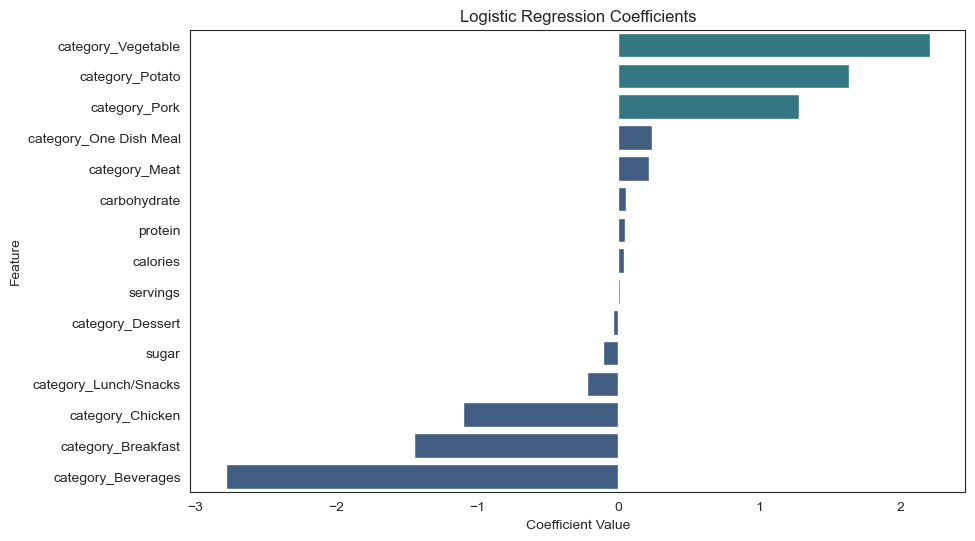

In [26]:
# Get feature coefficients from Logistic Regression model
logreg_coefs = logreg_model.coef_[0]

# Create a DataFrame to display feature names and their coefficients
logreg_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logreg_coefs})
logreg_feature_importance = logreg_feature_importance.sort_values(by='Coefficient', ascending=False)

# Set the color for specific categories
colors = ['#365c8d' if category not in ['category_Pork', 'category_Potato', 'category_Vegetable'] else '#277f8e' for category in logreg_feature_importance['Feature']]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=logreg_feature_importance, palette=colors)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Business Focus

The primary business goal of this project is to increase website traffic and, consequently, subscriptions by strategically selecting recipes to be displayed on the homepage. The aim was to predict and feature recipes that will attract high traffic, thereby capitalizing on the observed 40% increase in overall website visits when a popular recipe is showcased.

### 1. Category Level

According to the findings, the most popular high-traffic recipes are found in the Vegetable, Potato, and Pork categories. Conversely, Beverages, Breakfast, and Chicken recipes seem to lack the same level of appeal to visitors.

In [27]:
# Sort the table by High_Traffic_Percentage 
category_counts = category_counts.sort_values(by='High_Traffic_Percentage', ascending=False)

# Display the table
print(category_counts)

high_traffic   High  Low  Total  Portfolio_Share  High_Traffic_Percentage
category                                                                 
Vegetable        82    1     83             8.76                    98.80
Potato           83    5     88             9.29                    94.32
Pork             77    7     84             8.87                    91.67
Meat             59   20     79             8.34                    74.68
One Dish Meal    52   19     71             7.50                    73.24
Lunch/Snacks     57   32     89             9.40                    64.04
Dessert          53   30     83             8.76                    63.86
Chicken          73   99    172            18.16                    42.44
Breakfast        33   73    106            11.19                    31.13
Beverages         5   87     92             9.71                     5.43


### 2. Recipe Level

To address the business problem, the project involved building the Logistic Regression model that predicts the likelihood of a recipe leading to high traffic. This model is trained on historical data, considering various features such as recipe categories, ingredients, and number of servings. By analyzing patterns in past data, the model learnt to identify characteristics common to recipes that have historically attracted high traffic.

The model's output provides a probability score for each recipe, indicating the likelihood of it being popular. By integrating this model into the recipe selection process, the company can move away from relying solely on personal preferences and instead leverage data-driven insights to maximize website traffic.

The table below displays the first 15 recipes from the original dataset with the likelihood of it being popular.

Again, there is a consistent trend where recipes with the highest likelihood of gaining popularity fall within the Vegetable, Potato, and Pork categories. On the other hand, Beverages and Breakfast recipes appear to have a lower probability of becoming popular.

In [28]:
# Get probability scores for each recipe
probabilities = logreg_model.predict_proba(X)

# Create a DataFrame to display the recipe names and their probability scores
recipe_probabilities = pd.DataFrame({'Recipe': df['recipe'], 'Category': categories, 'Probability_High': probabilities[:, 1]})

# Display the probability scores
print(recipe_probabilities.head(15))

    Recipe       Category  Probability_High
0        1           Pork          0.881821
1        2         Potato          0.913475
2        3      Breakfast          0.331740
3        4      Beverages          0.086098
4        5      Beverages          0.107656
5        6  One Dish Meal          0.734244
6        7        Chicken          0.410632
7        8   Lunch/Snacks          0.627652
8        9           Pork          0.881766
9       10        Chicken          0.439313
10      11      Beverages          0.104915
11      12      Breakfast          0.312413
12      13         Potato          0.913295
13      14      Vegetable          0.944672
14      15           Meat          0.702838


## Business Metrics

The KPI to track is **Precision**. The business requirement is to achieve a precision of at least **80%**, ensuring a high confidence level in the accuracy of recipes predicted as high-traffic.

The precision values indicate the ability of each model to correctly identify instances that truly belong to the high traffic class among all instances predicted as positive. Here's how to interpret the results:

Logistic Regression Precision (0.8462):

- Out of all instances predicted as _High_ by the Logistic Regression model, approximately 84.62% were correctly identified as true positive cases.

Random Forest Precision (0.8304):

- For the Random Forest model, around 83.04% of instances predicted as _High_ were correctly classified as true positive cases.

In summary, both models exhibit high precision values, suggesting that when they predict a recipe to belong to the _High_ category, they are accurate and make relatively few false positive predictions. 


The higher precision for the Logistic Regression model indicates a slightly better performance in correctly identifying positive instances compared to the Random Forest model.

In [29]:
# Predictions for both models
y_pred_logreg = logreg_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# Calculate precision for both models
precision_logreg = precision_score(y_test, y_pred_logreg)
precision_rf = precision_score(y_test, y_pred_rf)

# Display precision for both models
print(f'Precision for Logistic Regression: {precision_logreg:.4f}')
print(f'Precision for Random Forest: {precision_rf:.4f}')

Precision for Logistic Regression: 0.8462
Precision for Random Forest: 0.8252


## Recommendation

1) Deploy the Logistic Regression Model:

The Logistic Regression model has demonstrated strong performance in predicting high-traffic recipes. It is recommended to leverage this model for the selection of recipes to be displayed on the homepage. The model's precision of approximately 84.62% indicates a high accuracy in identifying recipes that will lead to high traffic.

2) Monitor and Track Precision as a KPI:

Establish precision as a KPI for the model's success. Precision is crucial in the context of recipe selection, as it represents the accuracy of identifying recipes that will attract high traffic. Regularly monitor and track the precision of the model to ensure its ongoing effectiveness in predicting popular recipes.

3) Regular Model Maintenance and Updates:

Regularly update and retrain the Logistic Regression model as the dataset evolves and user preferences change. Continuous monitoring and adaptation to new patterns in recipe popularity will ensure the model's relevance and effectiveness over time.

4) Focus on High-Impact Categories:

Given that the Pork, Potato, and Vegetable categories have been identified as significant contributors to high-traffic recipes, consider focusing efforts on curating and promoting recipes from these categories. These categories have shown to have a positive impact on website traffic, and featuring more recipes from these categories could lead to increased user engagement.